# **Distance Predictor Part 4**
Author: Declan Costello

Date: 8/19/2023

## **Part 4 Description**

Here I Create pipelines with hyperparameter tuning Imputation, Scalling, One Hot encoding, and then use grid search for hyper parameter tuning utilizing the new features created in part 3

## **Table of Context**

1. [Installation](#Installation)
2. [Best Model ROI](#roi-on-chosen-model-from-grid-search-of-models)
    - GridSearchCV for Learning Rate(0.1)
    - GridSearchCV for Max Depth(5)
    - GridSearchCV for Min Child Weights(1)
    - RandomSearchCV for subsample(1.0)
    - HalvingGridSearchCV for N Estimators(20)
3. [Most Important Features](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.get_score)
4. SHAP

# **Installation**

The following installs the necessary packages

In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
from bokeh.io import output_notebook, show
from bokeh.models.tools import HoverTool
from bokeh.plotting import figure
from bokeh.layouts import row
output_notebook()

Loading BokehJS ...

In [3]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# **Data Import and Train Test Split**

In [4]:
data = pd.read_csv('FE_data.csv')

data.pop('Unnamed: 0')
data.pop('hc_x')
data.pop('hc_y')
data.pop('events')#...................
data.pop('woba_value')
data.pop('hit_distance_sc_percentile')
data.pop('launch_speed_percentile')
data.pop('release_speed_percentile')
#data.pop('launch_angle_binned')
#data.pop('pull_percent_binned')
data.pop('Pop_percentile')
data.pop('pitch_type')

# feature_cols = ['launch_angle','launch_speed',"release_speed","fav_platoon_split_for_batter","grouped_pitch_type","domed","game_elevation","is_barrel","Pop","pull_percent", "spray_angle"]
# X = data.loc[:, feature_cols]

# target_cols = ['hit_distance_sc']
# y = data.loc[:, target_cols]

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

0         SL
1         KC
2         FF
3         FC
4         FF
          ..
116149    FF
116150    FF
116151    CU
116152    FF
116153    ST
Name: pitch_type, Length: 116154, dtype: object

**Train Test Split**

In [5]:
feature_cols = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed", "domed", "spray_angle",'is_barrel','Pop','pull_percent']
#home_team
#stand
#p_throws
#grouped_pitch_type
#fav_platoon_split_for_batter

X = data.loc[:, feature_cols]

target_cols = ['hit_distance_sc']
y = data.loc[:, target_cols]

**[Stratify](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)**
- [I can only stratify three features because only working with ~100k rows](https://github.com/davidsbatista/text-classification/issues/1)
- [Eventual StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)

In [6]:
#one hot encode cats(home_team',"stands', 'p_throws') before split?
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=0,stratify = X[['domed']])

# **Search for Best XGBR Params**

In [7]:
param_range = [1, 2, 3, 4, 5, 6,10]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [5,10,15]
learning_rates = [.1,.2,.3]

# **Best XGB__learning_rate**

In [8]:
#XGBRegressor
pipe_xgb = Pipeline([('scl', StandardScaler()),
                     ('XGB', XGBRegressor(random_state=42))])

learning_rates = [.1,.2,.3, .4, .5, .6, .7, .8, .9]

#XGBRegressor
xgb_param_grid = [{'XGB__learning_rate': learning_rates}]

#XGBRegressor
xgb_grid_search = GridSearchCV(estimator=pipe_xgb,
        param_grid=xgb_param_grid,
        scoring='neg_mean_absolute_error',
        cv=3)

xgb_grid_search.fit(X_train, y_train.values.ravel())


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('XGB',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     i...
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             param_grid=[{'XGB__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                 0.7, 0.8, 0.9]}],
             scoring='neg_mean_absolute_error')

In [9]:
test = pd.DataFrame(xgb_grid_search.cv_results_)

x= test.param_XGB__learning_rate
y = test.mean_test_score

# Basic plot setup
p = figure(width=700, height=700, title='param_XGB__learning_rate VS Mean Test Score')
p.xaxis.axis_label = 'param_XGB__learning_rate'
p.yaxis.axis_label = 'Mean Test Score'

p.line(x, y, line_width=2, color='Blue')

cr = p.circle(x, y, size=10,
              fill_color="white", hover_fill_color="blue",
              fill_alpha=0.05, hover_alpha=0.8,
              line_color=None, hover_line_color="white")

p.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

#plot 2
x= test.param_XGB__learning_rate
y = test.mean_fit_time


z = figure(width=700, height=700, title='param_XGB__learning_rate VS Time')
z.xaxis.axis_label = 'param_XGB__learning_rate'
z.yaxis.axis_label = 'Time (Sec)'

z.line(x, y, line_width=2, color='red')

zr = z.triangle(x, y, size=10,
              fill_color="white", hover_fill_color="firebrick",
              fill_alpha=0.05, hover_alpha=0.8,
              line_color=None, hover_line_color="white")

z.add_tools(HoverTool(tooltips=None, renderers=[zr], mode='hline'))

show(row(p,z))

In [10]:
xgb_grid_search.best_params_

{'XGB__learning_rate': 0.1}

# **Best XGB__max_depth**

In [11]:
#XGBRegressor
pipe_xgb = Pipeline([('scl', StandardScaler()),
                     ('XGB', XGBRegressor(random_state=42))])

param_range = [1, 5, 10, 15, 20]

#XGBRegressor
xgb_param_grid = [{'XGB__max_depth': param_range}]

#XGBRegressor
xgb_grid_search = GridSearchCV(estimator=pipe_xgb,
        param_grid=xgb_param_grid,
        scoring='neg_mean_absolute_error',
        cv=3)

xgb_grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('XGB',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     i...
                                                     learning_rate=None,
                                                     max_bin=None,
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             param_grid=[{'XGB__max_depth': [1, 5, 10, 15, 20]}],
             scoring='neg_mean_absolute_error')

In [12]:
test = pd.DataFrame(xgb_grid_search.cv_results_)

x= test.param_XGB__max_depth
y = test.mean_test_score

# Basic plot setup
p = figure(width=700, height=700, title='param_XGB__max_depth VS Mean Test Score')
p.xaxis.axis_label = 'param_XGB__max_depth'
p.yaxis.axis_label = 'Mean Test Score'

p.line(x, y, line_width=2, color='Blue')

cr = p.circle(x, y, size=10,
              fill_color="white", hover_fill_color="blue",
              fill_alpha=0.05, hover_alpha=0.8,
              line_color=None, hover_line_color="white")

p.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

#plot 2
x= test.param_XGB__max_depth
y = test.mean_fit_time


z = figure(width=700, height=700, title='param_XGB__max_depth VS Time')
z.xaxis.axis_label = 'param_XGB__max_depth'
z.yaxis.axis_label = 'Time (Sec)'

z.line(x, y, line_width=2, color='red')

zr = z.triangle(x, y, size=10,
              fill_color="white", hover_fill_color="firebrick",
              fill_alpha=0.05, hover_alpha=0.8,
              line_color=None, hover_line_color="white")

z.add_tools(HoverTool(tooltips=None, renderers=[zr], mode='hline'))

show(row(p,z))

In [13]:
xgb_grid_search.best_params_

{'XGB__max_depth': 5}

# **Best XGB__min_child_weight**

In [14]:
##XGBRegressor
pipe_xgb = Pipeline([('scl', StandardScaler()),
                     ('XGB', XGBRegressor(random_state=42))])

min_child_weights = [1, 2, 3, 4, 5, 6, 7, 8, 9]

#XGBRegressor
xgb_param_grid = [{'XGB__min_child_weight': min_child_weights}]

#XGBRegressor
xgb_grid_search = GridSearchCV(estimator=pipe_xgb,
        param_grid=xgb_param_grid,
        scoring='neg_mean_absolute_error',
        cv=3)

xgb_grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('XGB',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     i...
                                                     max_bin=None,
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             param_grid=[{'XGB__min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8,
                                                    9]}],
             scoring='neg_mean_absolute_error')

In [15]:
test = pd.DataFrame(xgb_grid_search.cv_results_)

x= test.param_XGB__min_child_weight
y = test.mean_test_score

# Basic plot setup
p = figure(width=700, height=700, title='param_XGB__min_child_weight VS Mean Test Score')
p.xaxis.axis_label = 'param_XGB__min_child_weight'
p.yaxis.axis_label = 'Mean Test Score'

p.line(x, y, line_width=2, color='Blue')

cr = p.circle(x, y, size=10,
              fill_color="white", hover_fill_color="blue",
              fill_alpha=0.05, hover_alpha=0.8,
              line_color=None, hover_line_color="white")

p.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

#plot 2
x= test.param_XGB__min_child_weight
y = test.mean_fit_time


z = figure(width=700, height=700, title='param_XGB__min_child_weight VS Time')
z.xaxis.axis_label = 'param_XGB__min_child_weight'
z.yaxis.axis_label = 'Time (Sec)'

z.line(x, y, line_width=2, color='red')

zr = z.triangle(x, y, size=10,
              fill_color="white", hover_fill_color="firebrick",
              fill_alpha=0.05, hover_alpha=0.8,
              line_color=None, hover_line_color="white")

z.add_tools(HoverTool(tooltips=None, renderers=[zr], mode='hline'))

show(row(p,z))

In [16]:
xgb_grid_search.best_params_

{'XGB__min_child_weight': 5}

# **Best XGB__subsample [Using Random Search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318)**

In [17]:
# #XGBRegressor
# pipe_xgb = Pipeline([('scl', StandardScaler()),
#                      ('XGB', XGBRegressor(random_state=42))])

# param_range_fl = [2.0, 1.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

# #XGBRegressor
# xgb_param_grid = [{'XGB__subsample': param_range_fl}]

# #XGBRegressor
# xgb_grid_search = GridSearchCV(estimator=pipe_xgb,
#         param_grid=xgb_param_grid,
#         scoring='neg_mean_absolute_error',
#         cv=3)

# xgb_grid_search.fit(X_train, y_train.values.ravel())


# -------------

param_range_fl = [2.0, 1.5, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

param_grid = {
    'subsample': param_range_fl
}

rnd_search = RandomizedSearchCV(XGBRegressor(), param_grid, scoring='neg_mean_squared_error')

rnd_search.fit(X_train, y_train.values.ravel())


10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py", line 1025, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Library/Fr

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   param_distributions={'subsample': [2.0, 1.5, 1.0, 0.9, 0.8,
                                                      0.7, 0.6, 0.5, 0.4, 0.3,
                                                      0.2, 0.1]},
                   scoring='neg_mean_squared_error')

In [18]:
test = pd.DataFrame(rnd_search.cv_results_)

test = test.sort_values('param_subsample', ascending=False)


x= test.param_subsample
y = test.mean_test_score

# Basic plot setup
p = figure(width=700, height=700, title='param_XGB__subsample VS Mean Test Score')
p.xaxis.axis_label = 'param_XGB__subsample'
p.yaxis.axis_label = 'Mean Test Score'

p.line(x, y, line_width=2, color='Blue')

cr = p.circle(x, y, size=10,
              fill_color="white", hover_fill_color="blue",
              fill_alpha=0.05, hover_alpha=0.8,
              line_color=None, hover_line_color="white")

p.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

#plot 2
x= test.param_subsample
y = test.mean_fit_time


z = figure(width=700, height=700, title='param_XGB__subsample VS Time')
z.xaxis.axis_label = 'param_XGB__subsample'
z.yaxis.axis_label = 'Time (Sec)'

z.line(x, y, line_width=2, color='red')

zr = z.triangle(x, y, size=10,
              fill_color="white", hover_fill_color="firebrick",
              fill_alpha=0.05, hover_alpha=0.8,
              line_color=None, hover_line_color="white")

z.add_tools(HoverTool(tooltips=None, renderers=[zr], mode='hline'))

show(row(p,z))

In [19]:
rnd_search.best_params_

{'subsample': 1.0}

# **Best XGB__n_estimators [HalvingGridSearchCV](https://bobrupakroy.medium.com/halving-gridsearch-736b13898327)**

In [20]:
#XGBRegressor
xgb_param_grid = {"n_estimators": [1,5,10,15,20]}           


xgb_halving_search = HalvingGridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, scoring='neg_mean_squared_error')


In [21]:
xgb_halving_search.fit(X_train, y_train.values.ravel())

HalvingGridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                    param_grid={'n_estimators': [1, 5, 10, 15, 20]},
                    scoring='neg_mean_squared_error')

In [22]:
test = pd.DataFrame(xgb_halving_search.cv_results_)

x= test.param_n_estimators
y = test.mean_test_score

# Basic plot setup
p = figure(width=700, height=700, title='param_n_estimators VS Mean Test Score')
p.xaxis.axis_label = 'param_n_estimators'
p.yaxis.axis_label = 'Mean Test Score'

p.line(x, y, line_width=2, color='Blue')

cr = p.circle(x, y, size=10,
              fill_color="white", hover_fill_color="blue",
              fill_alpha=0.05, hover_alpha=0.8,
              line_color=None, hover_line_color="white")

p.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))


#plot 2
test = test.sort_values('param_n_estimators', ascending=False)

x= test.param_n_estimators
y = test.mean_fit_time


z = figure(width=700, height=700, title='param_n_estimators VS Time')
z.xaxis.axis_label = 'param_n_estimators'
z.yaxis.axis_label = 'Time (Sec)'

z.line(x, y, line_width=2, color='red')

zr = z.triangle(x, y, size=10,
              fill_color="white", hover_fill_color="firebrick",
              fill_alpha=0.05, hover_alpha=0.8,
              line_color=None, hover_line_color="white")

z.add_tools(HoverTool(tooltips=None, renderers=[zr], mode='hline'))

show(row(p,z))

In [23]:
xgb_halving_search.best_params_

{'n_estimators': 20}

**Data Import**

In [24]:
data = pd.read_csv('FE_data.csv')

**Preprocessing**

In [25]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer


numeric_features = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed", "domed", "spray_angle",'is_barrel','Pop','pull_percent']
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])


categorical_features = ["home_team","stand","p_throws",'grouped_pitch_type','fav_platoon_split_for_batter']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")


preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, numeric_features),
    ("cat_transform", categorical_transformer, categorical_features)
])

**XGBRegressor Pipeline**

In [26]:
XGBRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("Random Forest Regressor", XGBRegressor(XGB__learning_rate=0.1, max_depth=5, min_child_weight = 1, subsample = 1.0, n_estimators=10))])


**Train Test Split**

In [27]:
feature_cols = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed","home_team","stand","p_throws","fav_platoon_split_for_batter","grouped_pitch_type", "domed", "spray_angle",'is_barrel','Pop','pull_percent']
X = data.loc[:, feature_cols]

target_cols = ['hit_distance_sc']
y = data.loc[:, target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=0,stratify = X[['home_team',"stand",'grouped_pitch_type']])

**Most Important [Features](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.get_score) for Main Pipeline**

In [28]:
XGBRegressor_pipeline.fit(X_train, y_train.values.ravel())

coef = pd.Series(list(XGBRegressor_pipeline.steps[1][1].feature_importances_)[:10], index = X_train.columns[:10]).sort_values(ascending=True)
coef = coef.to_frame()
names = list(coef.index)
coef = coef.rename(columns={0: 'values'})
values = coef['values']

z = figure(y_range=names, height=500, width=500,title="Feature Importance")
z.hbar(y=names, right=values, width=0.9, color='skyblue')
z.x_range.start = 0
z.x_range.end = .9
z.xaxis.major_label_orientation = 1

p = figure(y_range=names[:7], height=500, width=500,title="Feature Importance")

p.hbar(y=names[:7], right=values[:7], width=0.9, color='skyblue')

p.x_range.start = 0
p.x_range.end = .012
p.xaxis.major_label_orientation = 1


show(row(z,p))

[20:58:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "XGB__learning_rate" } are not used.



# **[SHAP](https://medium.com/@akarabaev96/are-you-using-the-shap-library-to-its-full-potential-bb45efce2c9)**

In [29]:
#InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._voting.VotingRegressor'>
#InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

feature_cols = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed","domed", "spray_angle",'is_barrel','Pop','pull_percent']
X = data.loc[:, feature_cols]

target_cols = ['hit_distance_sc']
y = data.loc[:, target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=0)

ter_xg = XGBRegressor(XGB__learning_rate=0.1, max_depth=5, min_child_weight = 1, subsample = 1.0, n_estimators=10).fit(X_train, y_train.values.ravel())

explainer = shap.TreeExplainer(ter_xg, DMatrix=True)

shap_values = explainer(X_valid)


[20:58:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "XGB__learning_rate" } are not used.



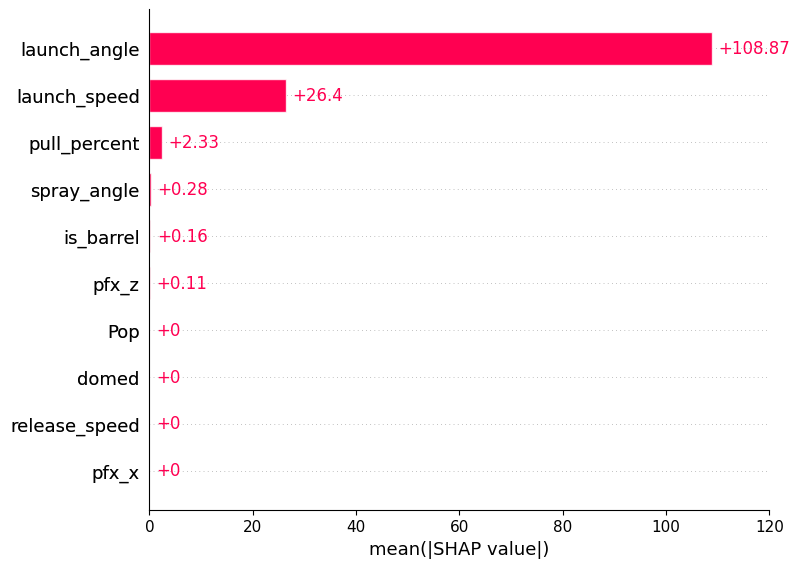

In [30]:
shap.initjs()
shap.plots.bar(shap_values)

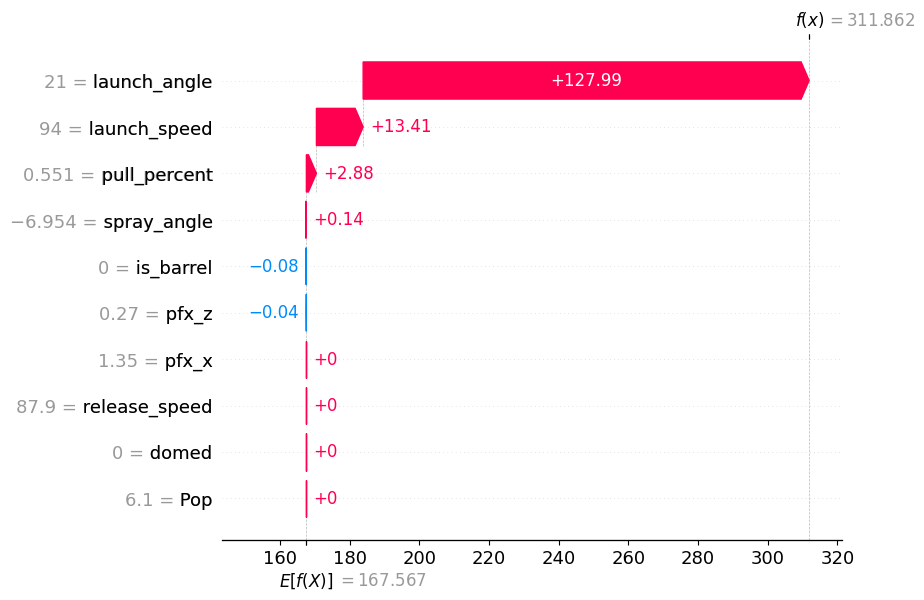

In [31]:
shap.plots.waterfall(shap_values[8])

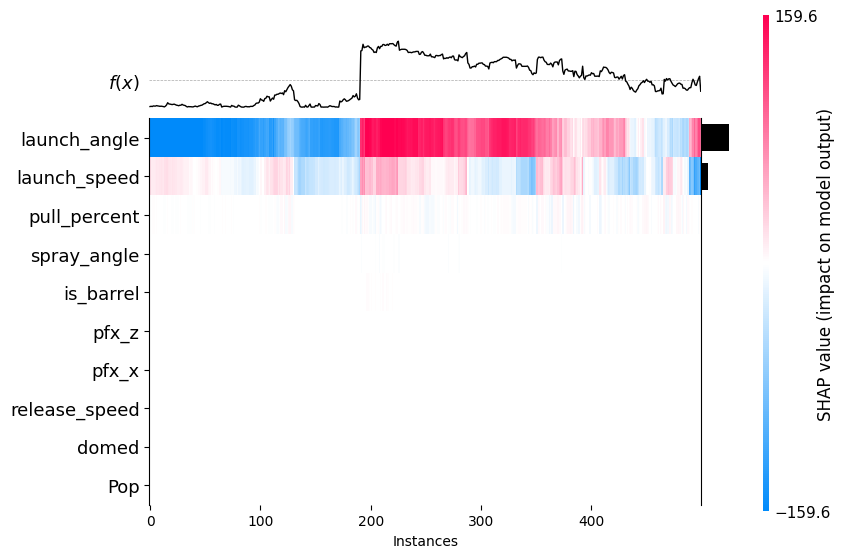

In [32]:
shap.plots.heatmap(shap_values[:500])

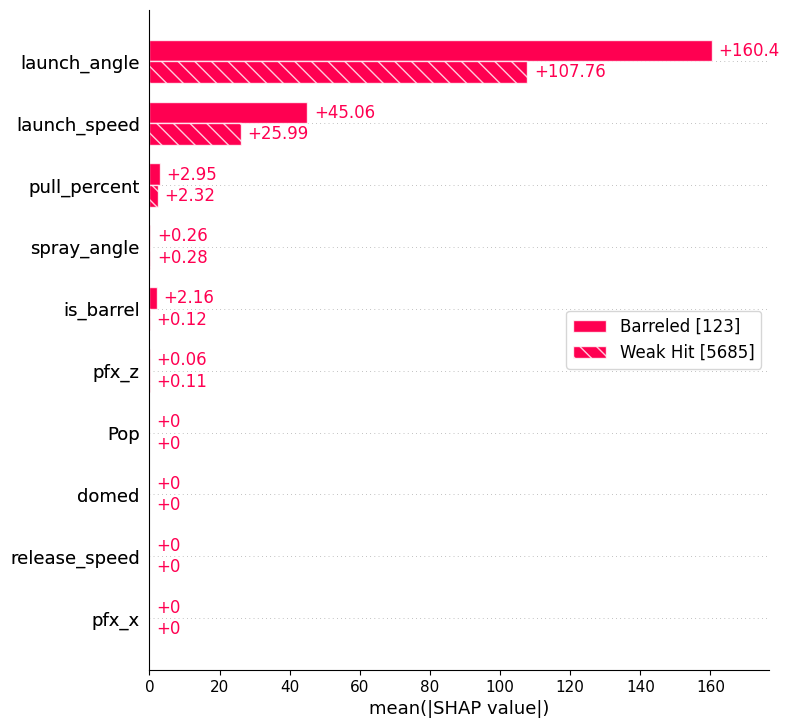

In [33]:
is_barrel = (
    X_valid['is_barrel']
    .apply(lambda is_barrel: 'Barreled' if is_barrel == 1 else 'Weak Hit')
    .values
)
shap.plots.bar(shap_values.cohorts(is_barrel).abs.mean(axis=0))

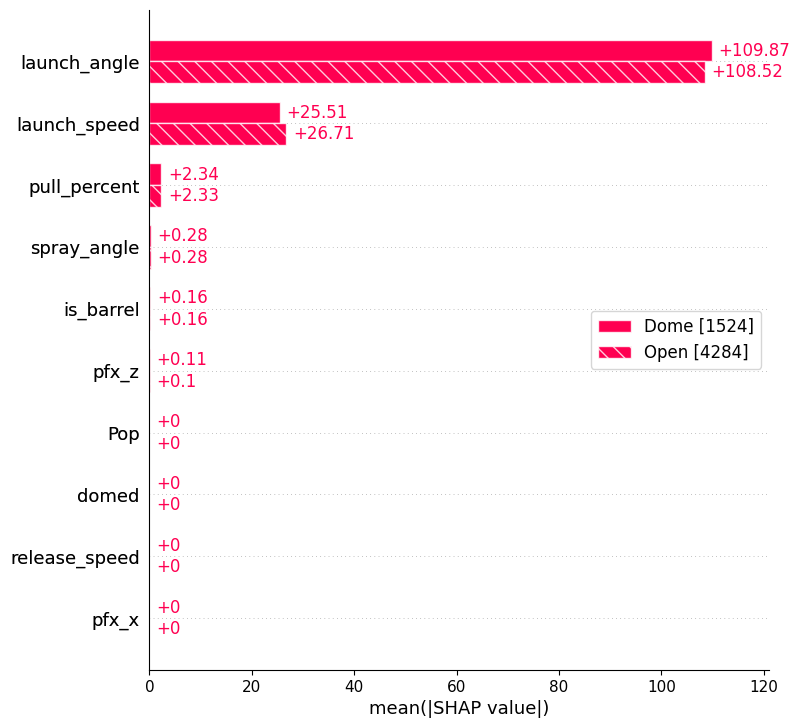

In [34]:
domed = (
    X_valid['domed']
    .apply(lambda domed: 'Dome' if domed == 1 else 'Open')
    .values
)
shap.plots.bar(shap_values.cohorts(domed).abs.mean(axis=0))

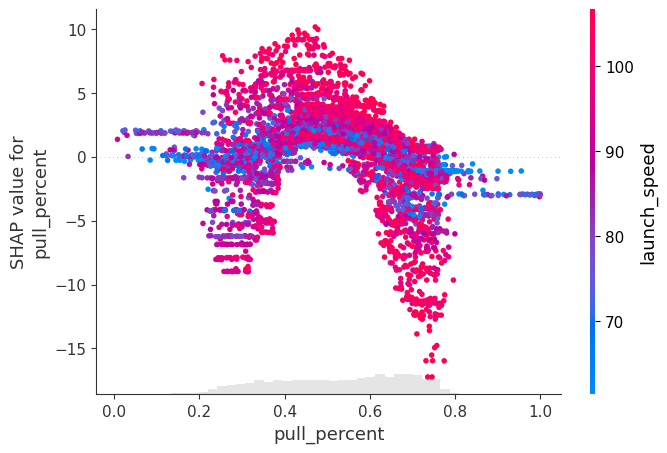

In [35]:
shap.plots.scatter(shap_values[:, 'pull_percent'], color = shap_values[:, 'launch_speed'])

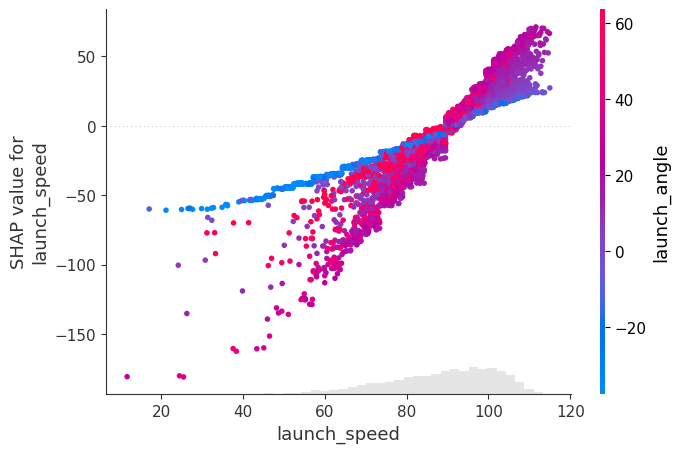

In [36]:
shap.plots.scatter(shap_values[:, 'launch_speed'], color = shap_values[:, 'launch_angle'])

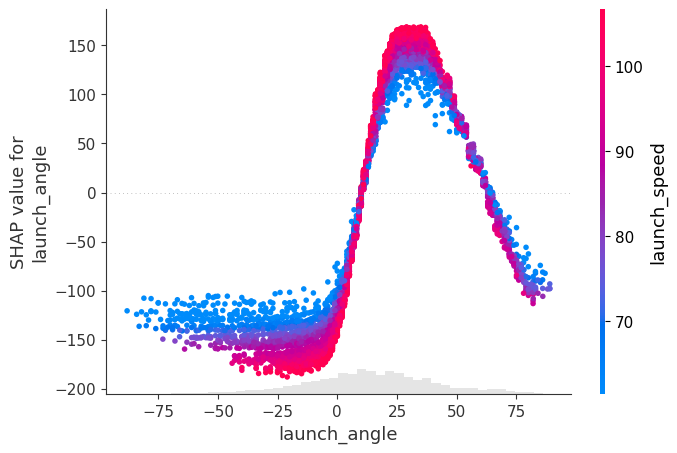

In [37]:
shap.plots.scatter(shap_values[:, 'launch_angle'], color = shap_values[:, 'launch_speed'])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


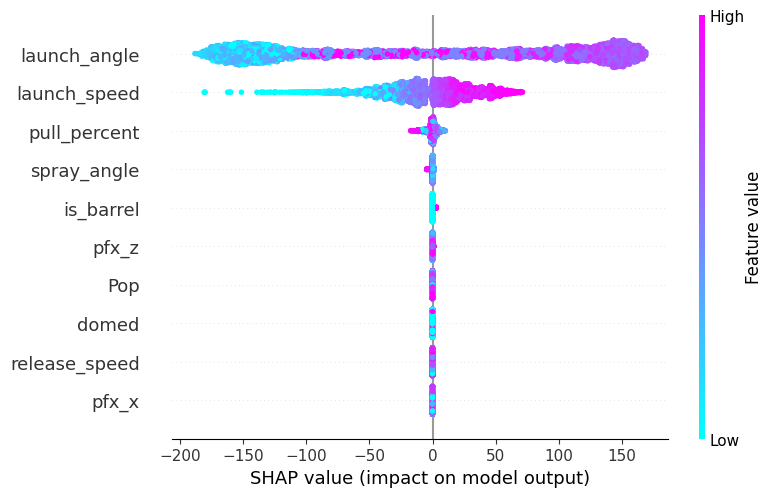

In [38]:
shap_values = explainer(X_valid)

shap.plots.beeswarm(shap_values, color='cool')


[20:58:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "XGB__learning_rate" } are not used.



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


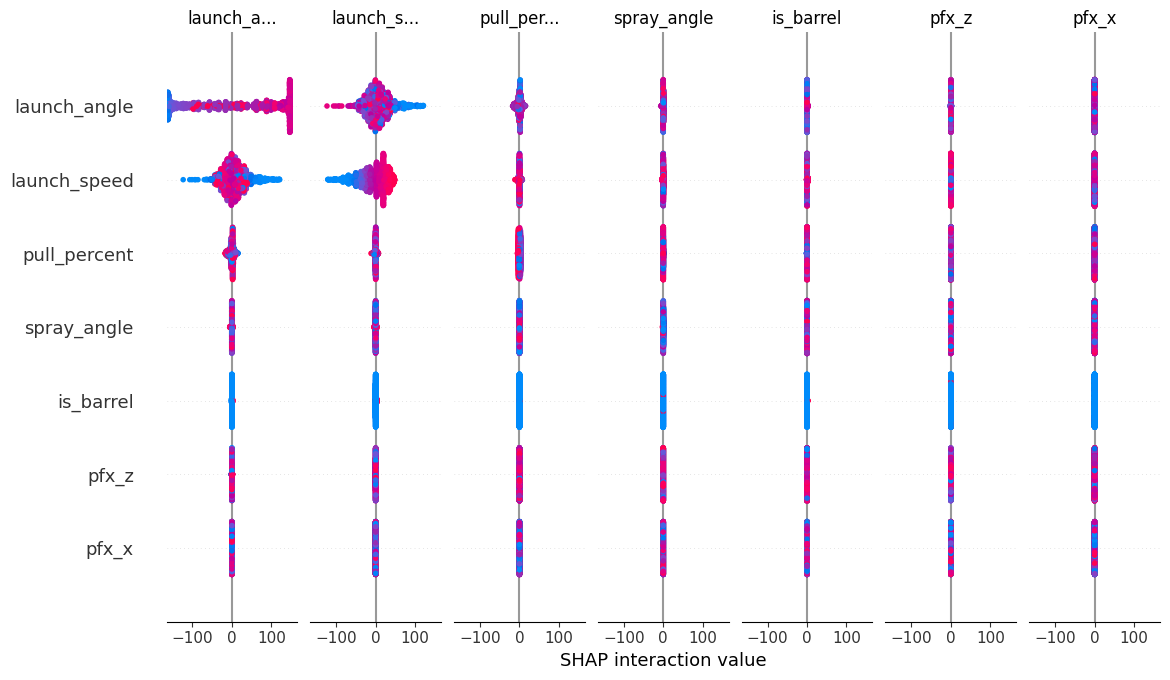

In [39]:

ter_xg = XGBRegressor(XGB__learning_rate=0.1, max_depth=5, min_child_weight = 1, subsample = 1.0, n_estimators=10).fit(X_train, y_train.values.ravel())

shap_interaction_values = shap.TreeExplainer(ter_xg).shap_interaction_values(X_train.iloc[:2000,:])

shap.summary_plot(shap_interaction_values, X_train.iloc[:2000,:])


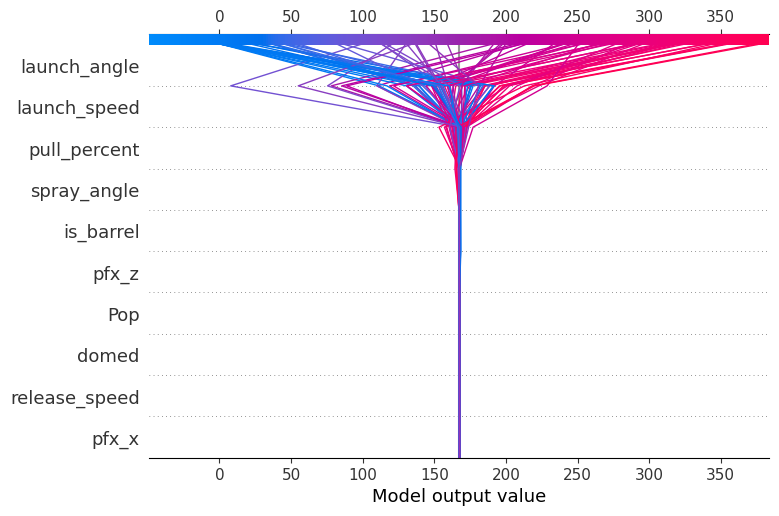

In [40]:
feat_names = X_valid.columns.to_numpy()

shap.decision_plot(explainer.expected_value, explainer.shap_values(X_valid)[:88], feat_names)

In [41]:
shap.plots.force(shap_values[0])

In [42]:
shap.plots.force(shap_values[:88])